In [1]:
from classes import ReachData

In [2]:
hm_dir = '/root/SRCclusters/results/EDZcode/8Jul2025/'
geomorph_path = hm_dir + 'network/reach_data.csv'
edz_path = hm_dir + 'analysis/data.csv'
reaches = ReachData(geomorphic_data_path=geomorph_path, edz_data_path=edz_path)

Input data shape: (193, 100)

Unconfined reaches without an extracted EDZ:
                    Segment Ph2SedReg
SRC_ID                               
1             118_M15T1.03A       DEP
41            118_M40T5.01C     FSTCD
45            118_M40T5.03A       UST
53            118_M41T6.02B       UST
80      19_M05T03.02S01.02B      CEFD
129                 26_M02-     FSTCD
181                 27_M23-       UST
188               27_T4.02A       UST
189               27_T4.02B     FSTCD
190               27_T4.05A       UST
193               27_T4.05D       UST

Shape after dropping unconfined NaNs: (182, 100)
Ph2SedReg
UST      56
CEFD     47
FSTCD    43
TR       26
CST       8
DEP       2
Name: count, dtype: int64



In [3]:
reach_avg_dir = hm_dir + 'geometry/'
reaches.load_reach_avg_profiles(reach_avg_dir)

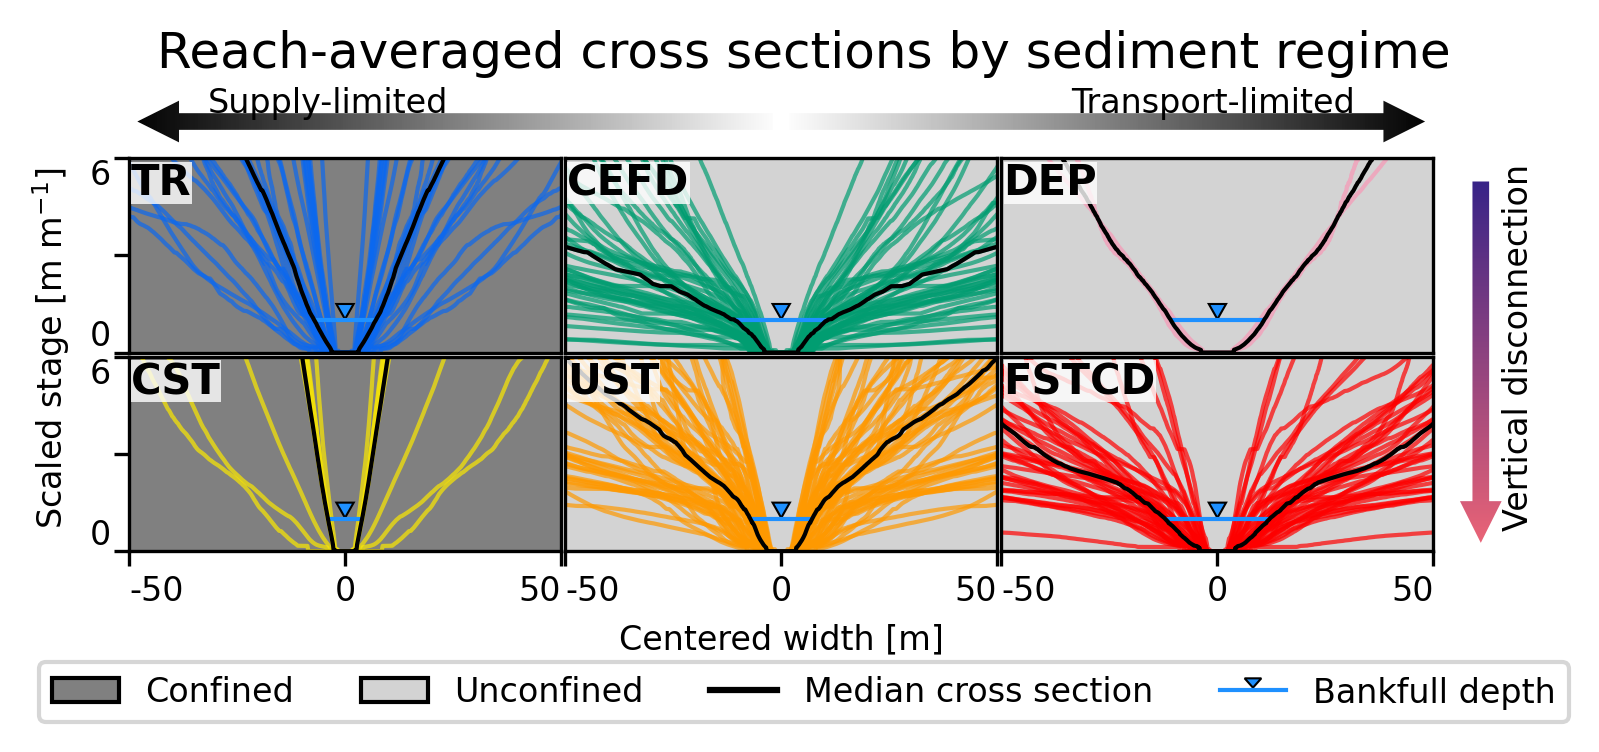

In [4]:
fig = reaches.plot_reconstructed_xsecs_paper()

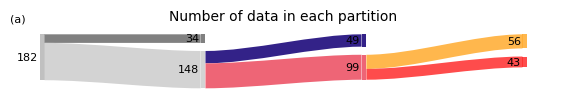

In [5]:
fig = reaches.plot_sankey_diagram()

KS test p-value for VC: 1.8380786716182389e-22
KS test p-value for EDZ rel width: 4.377245235422289e-09
KS test p-value for IR: 6.32193172057836e-30
KS test p-value for EDZ access: 4.752661156570958e-07
KS test p-value for WtoD field: 5.5444659166562714e-06
KS test p-value for WtoD DEM: 3.157442017378531e-05


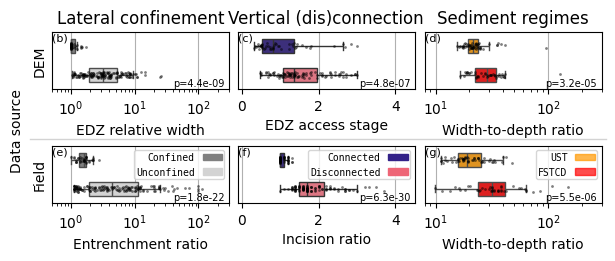

In [6]:
fig = reaches.plot_boxplots_paper()